# 实战Kaggle比赛——使用Gluon预测房价和K折交叉验证

本章介绍如何使用``Gluon``来实战[Kaggle比赛](https://www.kaggle.com)。我们以[房价预测问题](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)为例，为大家提供一整套实战中常常需要的工具，例如**K折交叉验证**。我们还以``pandas``为工具介绍如何对**真实世界**中的数据进行重要的预处理，例如：

* 处理离散数据
* 处理丢失的数据特征
* 对数据进行标准化

需要注意的是，本章仅提供一些基本实战流程供大家参考。对于数据的预处理、模型的设计和参数的选择等，我们特意只提供最基础的版本。希望大家一定要通过动手实战、仔细观察实验现象、认真分析实验结果并不断调整方法，从而得到令自己满意的结果。

这是一次宝贵的实战机会，我们相信你一定能从动手的过程中学到很多。

> Get your hands dirty。

## Kaggle中的房价预测问题

[Kaggle](https://www.kaggle.com)是一个著名的供机器学习爱好者交流的平台。为了便于提交结果，请大家注册[Kaggle](https://www.kaggle.com)账号。请注意，**目前Kaggle仅限每个账号一天以内10次提交结果的机会**。所以提交结果前务必三思。

![](../img/kaggle.png)




我们以[房价预测问题](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)为例教大家如何实战一次Kaggle比赛。请大家在动手开始之前点击[房价预测问题](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)了解相关信息。

![](../img/house_pricing.png)



## 读入数据

比赛数据分为训练数据集和测试数据集。两个数据集都包括每个房子的特征，例如街道类型、建造年份、房顶类型、地下室状况等特征值。这些特征值有连续的数字、离散的标签甚至是缺失值'na'。只有训练数据集包括了我们需要在测试数据集中预测的每个房子的价格。数据可以从[房价预测问题](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)中下载。

[训练数据集下载地址](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/download/train.csv)
[测试数据集下载地址](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/download/test.csv)

我们通过使用``pandas``读入数据。请确保安装了``pandas`` (``pip install pandas``)。

In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv("../data/kaggle_house_pred_train.csv")
test = pd.read_csv("../data/kaggle_house_pred_test.csv")
all_X = pd.concat((train.loc[:, 'MSSubClass':'SaleCondition'],
                      test.loc[:, 'MSSubClass':'SaleCondition']))

我们看看数据长什么样子。

In [2]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


数据大小如下。

In [3]:
train.shape

(1460, 81)

In [4]:
test.shape

(1459, 80)

## 预处理数据

我们使用pandas对数值特征做标准化处理：

$$x_i = \frac{x_i - \mathbb{E} x_i}{\text{std}(x_i)}。$$

In [5]:
numeric_feats = all_X.dtypes[all_X.dtypes != "object"].index
all_X[numeric_feats] = all_X[numeric_feats].apply(lambda x: (x - x.mean())
                                                            / (x.std()))

现在把离散数据点转换成数值标签。

In [6]:
all_X = pd.get_dummies(all_X, dummy_na=True)

把缺失数据用本特征的平均值估计。

In [7]:
all_X = all_X.fillna(all_X.mean())

下面把数据转换一下格式。

In [8]:
num_train = train.shape[0]

X_train = all_X[:num_train].as_matrix()
X_test = all_X[num_train:].as_matrix()
y_train = train.SalePrice.as_matrix()

## 导入NDArray格式数据

为了便于和``Gluon``交互，我们需要导入NDArray格式数据。

In [9]:
from mxnet import ndarray as nd
from mxnet import autograd
from mxnet import gluon

X_train = nd.array(X_train)
y_train = nd.array(y_train)
y_train.reshape((num_train, 1))

X_test = nd.array(X_test)

我们把损失函数定义为平方误差。

In [10]:
square_loss = gluon.loss.L2Loss()

我们定义比赛中测量结果用的函数。

In [11]:
def get_rmse_log(net, X_train, y_train):
    num_train = X_train.shape[0]
    clipped_preds = nd.clip(net(X_train), 1, float('inf'))
    return np.sqrt(2 * nd.sum(square_loss(
        nd.log(clipped_preds), nd.log(y_train))).asscalar() / num_train)

## 定义模型

我们将模型的定义放在一个函数里供多次调用。这是一个基本的线性回归模型。

In [12]:
def get_net():
    net = gluon.nn.Sequential()
    with net.name_scope():
        net.add(gluon.nn.Dense(1))
    net.initialize()
    return net

我们定义一个训练的函数，这样在跑不同的实验时不需要重复实现相同的步骤。

In [13]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

def train(net, X_train, y_train, X_test, y_test, epochs, 
          verbose_epoch, learning_rate, weight_decay):
    train_loss = []
    if X_test is not None:
        test_loss = []
    batch_size = 100
    dataset_train = gluon.data.ArrayDataset(X_train, y_train)
    data_iter_train = gluon.data.DataLoader(
        dataset_train, batch_size,shuffle=True)
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                            {'learning_rate': learning_rate,
                             'wd': weight_decay})
    net.collect_params().initialize(force_reinit=True)
    for epoch in range(epochs):
        for data, label in data_iter_train:
            with autograd.record():
                output = net(data)
                loss = square_loss(output, label)
            loss.backward()
            trainer.step(batch_size)

            cur_train_loss = get_rmse_log(net, X_train, y_train)
        if epoch > verbose_epoch:
            print("Epoch %d, train loss: %f" % (epoch, cur_train_loss))
        train_loss.append(cur_train_loss)
        if X_test is not None:    
            cur_test_loss = get_rmse_log(net, X_test, y_test)
            test_loss.append(cur_test_loss)
    plt.plot(train_loss)
    plt.legend(['train'])
    if X_test is not None:
        plt.plot(test_loss)
        plt.legend(['train','test'])
    plt.show()
    if X_test is not None:
        return cur_train_loss, cur_test_loss
    else:
        return cur_train_loss

## K折交叉验证

在[过拟合](underfit-overfit.md)中我们讲过，过度依赖训练数据集的误差来推断测试数据集的误差容易导致过拟合。事实上，当我们调参时，往往需要基于K折交叉验证。

> 在K折交叉验证中，我们把初始采样分割成$K$个子样本，一个单独的子样本被保留作为验证模型的数据，其他$K-1$个样本用来训练。

我们关心K次验证模型的测试结果的平均值和训练误差的平均值，因此我们定义K折交叉验证函数如下。

In [14]:
def k_fold_cross_valid(k, epochs, verbose_epoch, X_train, y_train,
                       learning_rate, weight_decay):
    assert k > 1
    fold_size = X_train.shape[0] // k
    train_loss_sum = 0.0
    test_loss_sum = 0.0
    for test_i in range(k):
        X_val_test = X_train[test_i * fold_size: (test_i + 1) * fold_size, :]
        y_val_test = y_train[test_i * fold_size: (test_i + 1) * fold_size]

        val_train_defined = False
        for i in range(k):
            if i != test_i:
                X_cur_fold = X_train[i * fold_size: (i + 1) * fold_size, :]
                y_cur_fold = y_train[i * fold_size: (i + 1) * fold_size]
                if not val_train_defined:
                    X_val_train = X_cur_fold
                    y_val_train = y_cur_fold
                    val_train_defined = True
                else:
                    X_val_train = nd.concat(X_val_train, X_cur_fold, dim=0)
                    y_val_train = nd.concat(y_val_train, y_cur_fold, dim=0)
        net = get_net()
        train_loss, test_loss = train(
            net, X_val_train, y_val_train, X_val_test, y_val_test, 
            epochs, verbose_epoch, learning_rate, weight_decay)
        train_loss_sum += train_loss
        print("Test loss: %f" % test_loss)
        test_loss_sum += test_loss
    return train_loss_sum / k, test_loss_sum / k

### 训练模型并交叉验证

以下的模型参数都是可以调的。

In [15]:
k = 5
epochs = 100
verbose_epoch = 95
learning_rate = 5
weight_decay = 0.0

给定以上调好的参数，接下来我们训练并交叉验证我们的模型。

Epoch 96, train loss: 0.201782
Epoch 97, train loss: 0.199687
Epoch 98, train loss: 0.197705
Epoch 99, train loss: 0.195808


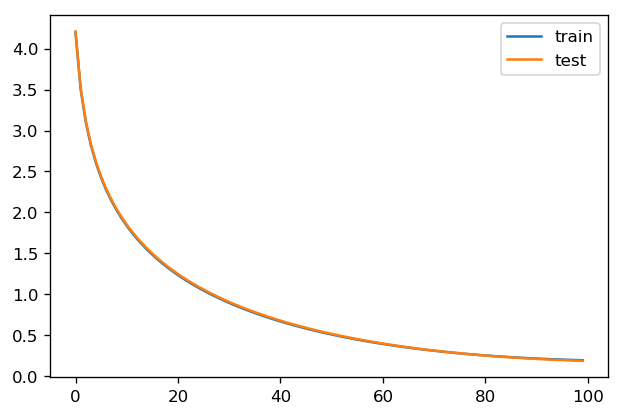

Test loss: 0.188878


Epoch 96, train loss: 0.198062
Epoch 97, train loss: 0.195873
Epoch 98, train loss: 0.193825
Epoch 99, train loss: 0.191883


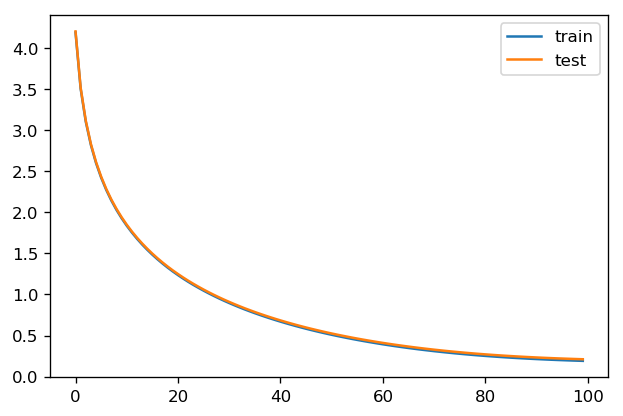

Test loss: 0.211598


Epoch 96, train loss: 0.199231
Epoch 97, train loss: 0.197052
Epoch 98, train loss: 0.194974
Epoch 99, train loss: 0.193080


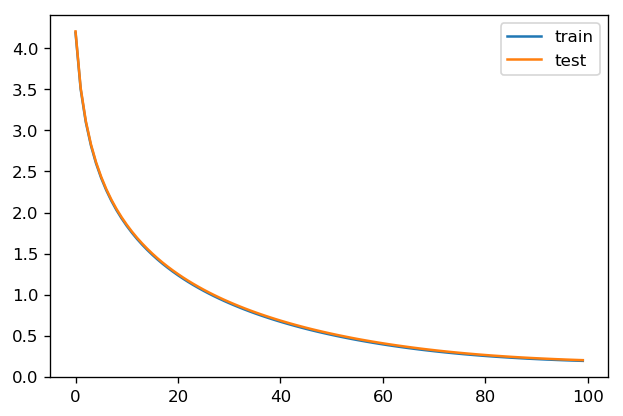

Test loss: 0.201594


Epoch 96, train loss: 0.201768
Epoch 97, train loss: 0.199616
Epoch 98, train loss: 0.197542
Epoch 99, train loss: 0.195638


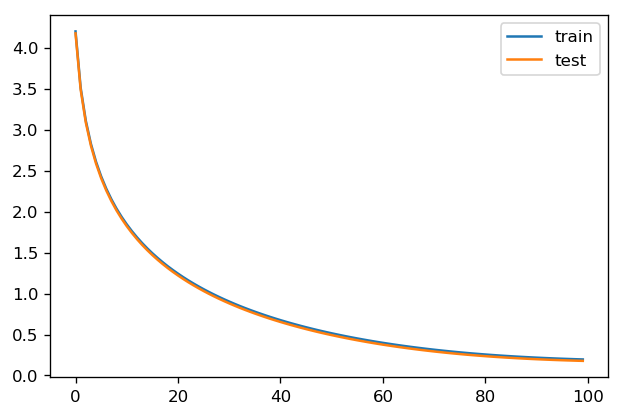

Test loss: 0.178395


Epoch 96, train loss: 0.196731
Epoch 97, train loss: 0.194543
Epoch 98, train loss: 0.192444
Epoch 99, train loss: 0.190461


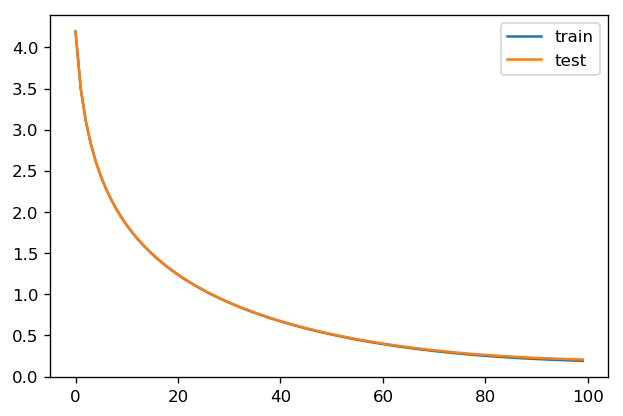

Test loss: 0.206647
5-fold validation: Avg train loss: 0.193374, Avg test loss: 0.197422


In [16]:
train_loss, test_loss = k_fold_cross_valid(k, epochs, verbose_epoch, X_train,
                                           y_train, learning_rate, weight_decay)
print("%d-fold validation: Avg train loss: %f, Avg test loss: %f" %
      (k, train_loss, test_loss))

即便训练误差可以达到很低（调好参数之后），但是K折交叉验证上的误差可能更高。当训练误差特别低时，要观察K折交叉验证上的误差是否同时降低并小心过拟合。我们通常依赖K折交叉验证误差结果来调节参数。



## 预测并在Kaggle提交预测结果（选学）

本部分为选学内容。网络不好的同学可以通过上述K折交叉验证的方法来评测自己训练的模型。

我们首先定义预测函数。

In [17]:
def learn(epochs, verbose_epoch, X_train, y_train, test, learning_rate,
          weight_decay):
    net = get_net()
    train(net, X_train, y_train, None, None, epochs, verbose_epoch, 
          learning_rate, weight_decay)
    preds = net(X_test).asnumpy()
    test['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test['Id'], test['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

调好参数以后，下面我们预测并在Kaggle提交预测结果。

Epoch 96, train loss: 0.170990
Epoch 97, train loss: 0.170420
Epoch 98, train loss: 0.169890
Epoch 99, train loss: 0.169408


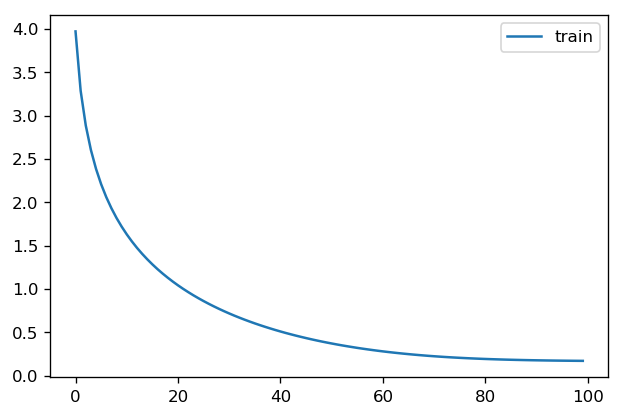

In [18]:
learn(epochs, verbose_epoch, X_train, y_train, test, learning_rate,
      weight_decay)

执行完上述代码后，会生成一个`submission.csv`文件。这是Kaggle要求的提交格式。这时我们可以在Kaggle上把我们预测得出的结果提交并查看与测试数据集上真实房价的误差。你需要登录Kaggle网站，打开[房价预测问题地址](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)，并点击下方右侧`Submit Predictions`按钮提交。

![](../img/kaggle_submit.png)



请点击下方`Upload Submission File`选择需要提交的预测结果。然后点击下方的`Make Submission`按钮就可以查看结果啦！

![](../img/kaggle_submit2.png)

再次温馨提醒，**目前Kaggle仅限每个账号一天以内10次提交结果的机会**。所以提交结果前务必三思。

## 作业（[汇报作业和查看其他小伙伴作业](https://discuss.gluon.ai/t/topic/1039)）：

* 运行本教程，目前的模型在5折交叉验证上可以拿到什么样的loss？
* 如果网络条件允许，在Kaggle提交本教程的预测结果。观察一下，这个结果能在Kaggle上拿到什么样的loss？
* 通过重新设计模型、调参并对照K折交叉验证结果，新模型是否比其他小伙伴的更好？除了调参，你可能发现我们之前学过的以下内容有些帮助：
    * [多层感知机 --- 使用Gluon](mlp-gluon.md)
    * [正则化 --- 使用Gluon](reg-gluon.md)
* 如果不使用对数值特征做标准化处理能拿到什么样的loss？
* 你还有什么其他办法可以继续改进模型？小伙伴们都期待学习到你独特的富有创造力的解决方案。

**吐槽和讨论欢迎点**[这里](https://discuss.gluon.ai/t/topic/1039)